## PU learning

In [1]:
from scipy import signal
from scipy import stats
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd

In [2]:
import sklearn as sk
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn import metrics

### Data Creating

Let's create some syntetic data based on gaussian windows.

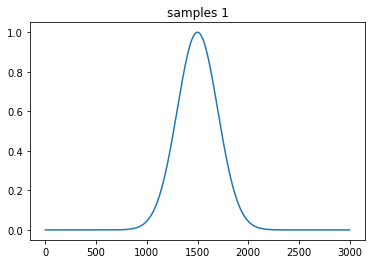

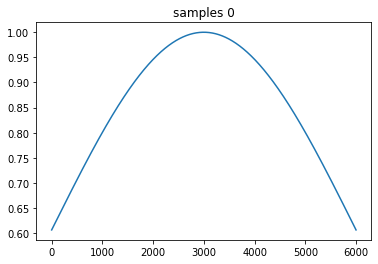

In [3]:
gaussian_arr1 = signal.gaussian(3000, std=200)
plt.plot(gaussian_arr1)
plt.title("samples 1")
plt.show()
gaussian_arr0 = signal.gaussian(6000, std=3000) 
plt.plot(gaussian_arr0)
plt.title("samples 0")
plt.show()

Mixing the datas to dataframe with correct labels

In [4]:
df = pd.DataFrame(data=np.vstack((np.stack(
    (gaussian_arr1, [1]*len(gaussian_arr1)), axis=-1),np.stack((gaussian_arr0, [0]*len(gaussian_arr0)), axis=-1))), 
    columns=["x", "y"]) #1 - for gaussian 0 - for laplaccian

Suffling whole data.

In [5]:
df = df.sample(frac=1).reset_index(drop=True)

In [6]:
df.head()

,x,y
0,0.778584,0.0
1,0.727601,0.0
2,0.955278,1.0
3,0.058534,1.0
4,0.000004,1.0


### Normal classifier, normal data example

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df["x"], df["y"], test_size=0.33, random_state=42)

As an exaple of classifier i would use Random Forest classifier from sklearn lib, course it one of the mentioned classifiers in article and can be easily replaced with any other from sklearn with no code changes.

In [8]:
classifier = RandomForestClassifier
params = {"n_estimators":100, "max_depth":2, "random_state":0}
# calssifier = LogisticRegression
# params = {"solver":'lbfgs'}

In [9]:
CL_ex = classifier(**params)
CL_ex.fit(X_train.values.reshape(-1, 1), y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [10]:
y_pred = CL_ex.predict(X_test.values.reshape(-1, 1))
print(f"acc is {accuracy_score(y_test, y_pred):.4f}, "
      f"f1 is {f1_score(y_test, y_pred):.4f}, "
      f"roc is {roc_auc_score(y_test, y_pred):.4f}")

acc is 0.9515, f1 is 0.9238, roc is 0.9292


Let's make some of the data undefined.

In [11]:
df["s"] = df["y"] * np.random.randint(0,2,len(df))

In [12]:
df.head()

,x,y,s
0,0.778584,0.0,0.0
1,0.727601,0.0,0.0
2,0.955278,1.0,1.0
3,0.058534,1.0,1.0
4,0.000004,1.0,0.0


In [13]:
X_train, X_test, y_train, y_test = train_test_split(df["x"], df[["s","y"]], test_size=0.33, random_state=42)

In [14]:
CL_ex = classifier(**params)
CL_ex.fit(X_train.values.reshape(-1, 1), y_train["s"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

Ordinary classifier works bad with undefined data - it can't learn unreal dependense (will the value be def or undef) and can't learn real dependense - undefined data mixes everething two much.

In [15]:
CL_ex.predict(X_test.values.reshape(-1, 1))
print(f"Score for s is {CL_ex.score(X_test.values.reshape(-1, 1),y_test['s']):.4f}, course unreal dependense is hard to learn")
print(f"Score for y is {CL_ex.score(X_test.values.reshape(-1, 1),y_test['y']):.4f} course real dependense is hard to learn from unreal")
expected = y_test["y"]
predicted = CL_ex.predict(X_test.values.reshape(-1, 1))

print("Classification report for classifier %s:\n%s\n"
      % (CL_ex, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Score for s is 0.8347, course unreal dependense is hard to learn
Score for y is 0.7680 course real dependense is hard to learn from unreal
Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False):
              precision    recall  f1-score   support

         0.0       0.74      1.00      0.85      1953
         1.0       1.00      0.32      0.49      1017

    accuracy                           0.77      2970
   macro avg       0.87      0.66      0.67      2970
weighted avg       0.83      0.77      0.73      2970


Confusion 

Let's build classifier, that would cope with defined-undefined data.

### Divide data

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df["x"], df[["s", 'y']], test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

### Fit g classificator

In [17]:
CL_g = classifier(**params)
CL_g.fit(X_train.values.reshape(-1, 1), y_train["s"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

### Estimating c

As written in article c is probability that if data is type 1 - it will be defined data that can be estimated via classifier g, builded on Def/Undef data

There are three ways to estimate c, described in article.

In [18]:
X_val_p = X_val.loc[X_val.index[y_val["s"] == 1]]
d_p = CL_g.predict_proba(X_val_p.values.reshape(-1, 1))[:,1]
e1 = d_p.sum()/len(X_val_p)
e1

0.42972074896177836

In [19]:
d_v = CL_g.predict_proba(X_val.values.reshape(-1, 1))[:,1]
e2 = d_p.sum()/d_v.sum()
e2

0.4531545827111744

In [20]:
e3 = d_v.max()
e3

0.5962930238667754

### First way to create f classificator

###### IT IS NOT THE PART OF ARTICLE
While i was reading article, i had an idea that classifier could be easily improved with deviding result on c.

In [21]:
CL_f = classifier(**params)
CL_f.fit(X_train.values.reshape(-1, 1), y_train["s"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [22]:
c = e1 # e2 or e3
y_pred = np.array(CL_f.predict_proba(X_test.values.reshape(-1,1))[:,1]/c > 0.5, dtype=int)
accuracy_score(y_test["y"],y_pred)

0.9508417508417508

### Second way to improve classifier f

The way, that was used by the authors of article is to create weights of each sample build on g prediction for value and parametr c.

In [23]:
def create_new_train(e, X_train, y_train, CL):
    X_train_new = pd.DataFrame(X_train.loc[y_train.index[y_train["s"] == 1]])
    X_train_new["w"] = 1
    y_train_new = pd.DataFrame([1]*len(X_train_new), columns=["s"])
    X_train_1 = pd.DataFrame(X_train.loc[y_train.index[y_train["s"] == 0]])
    g_x = CL.predict_proba(X_train_1["x"].values.reshape(-1,1))[:,1]
    X_train_1["w"] = (1-e)/e * g_x/(1-g_x)
    y_train_1 = pd.DataFrame([1]*len(X_train_1), columns=["s"])
    X_train_2 = pd.DataFrame(X_train.loc[y_train.index[y_train["s"] == 0]])
    g_x = CL.predict_proba(X_train_2["x"].values.reshape(-1,1))[:,1]
    X_train_2["w"] = 1 - (1-e)/e * g_x/ (1-g_x)
    y_train_2 = pd.DataFrame([0]*len(X_train_2), columns=["s"])
    X_train_new = X_train_new.append(X_train_1, ignore_index=True, sort=False)
    X_train_new = X_train_new.append(X_train_2, ignore_index=True, sort=False)
    y_train_new = y_train_new.append(y_train_1, ignore_index=True, sort=False)
    y_train_new = y_train_new.append(y_train_2, ignore_index=True, sort=False)
    return X_train_new, y_train_new

#### e1

In [24]:
CL_f = classifier(**params)
X_train_new, y_train_new = create_new_train(e1, X_train, y_train, CL_g)
CL_f.fit(X_train_new['x'].values.reshape(-1, 1), y_train_new["s"], sample_weight=X_train_new['w'])
y_pred = CL_f.predict(X_test.values.reshape(-1, 1))
expected = y_test["y"]
predicted = CL_f.predict(X_test.values.reshape(-1,1))

print("Classification report for classifier %s:\n%s\n"
      % (CL_f, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False):
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96      1953
         1.0       1.00      0.86      0.92      1017

    accuracy                           0.95      2970
   macro avg       0.97      0.93      0.94      2970
weighted avg       0.95      0.95      0.95      2970


Confusion matrix:
[[1953    0]
 [ 146  871]]


#### e2

In [25]:
CL_f = classifier(**params)
X_train_new, y_train_new = create_new_train(e2, X_train, y_train, CL_g)
CL_f.fit(X_train_new['x'].values.reshape(-1, 1), y_train_new["s"], sample_weight=X_train_new['w'])
expected = y_test["y"]
predicted = CL_f.predict(X_test.values.reshape(-1,1))

print("Classification report for classifier %s:\n%s\n"
      % (CL_f, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False):
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96      1953
         1.0       1.00      0.86      0.92      1017

    accuracy                           0.95      2970
   macro avg       0.97      0.93      0.94      2970
weighted avg       0.95      0.95      0.95      2970


Confusion matrix:
[[1953    0]
 [ 146  871]]


#### e3

In [26]:
CL_f = classifier(**params)
X_train_new, y_train_new = create_new_train(e3, X_train, y_train, CL_g)
CL_f.fit(X_train_new['x'].values.reshape(-1, 1), y_train_new["s"], sample_weight=X_train_new['w'])
expected = y_test["y"]
predicted = CL_f.predict(X_test.values.reshape(-1,1))

print("Classification report for classifier %s:\n%s\n"
      % (CL_f, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Classification report for classifier RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False):
              precision    recall  f1-score   support

         0.0       0.93      1.00      0.96      1953
         1.0       1.00      0.86      0.92      1017

    accuracy                           0.95      2970
   macro avg       0.97      0.93      0.94      2970
weighted avg       0.95      0.95      0.95      2970


Confusion matrix:
[[1953    0]
 [ 146  871]]


It can be noticed that on suntetic data all estimation of c is nearly equal.